Graph Nodes:
[(1, {'type': 'Activity', 'description': 'Suspicious login detected from multiple locations within a short time span.'}), (2, {'type': 'IoC', 'description': 'IP address 192.168.1.1, associated with suspicious activity'}), (3, {'type': 'Activity', 'description': 'File download from unknown source observed on multiple machines'})]

Graph Edges:
[(1, 2, {}), (2, 3, {})]


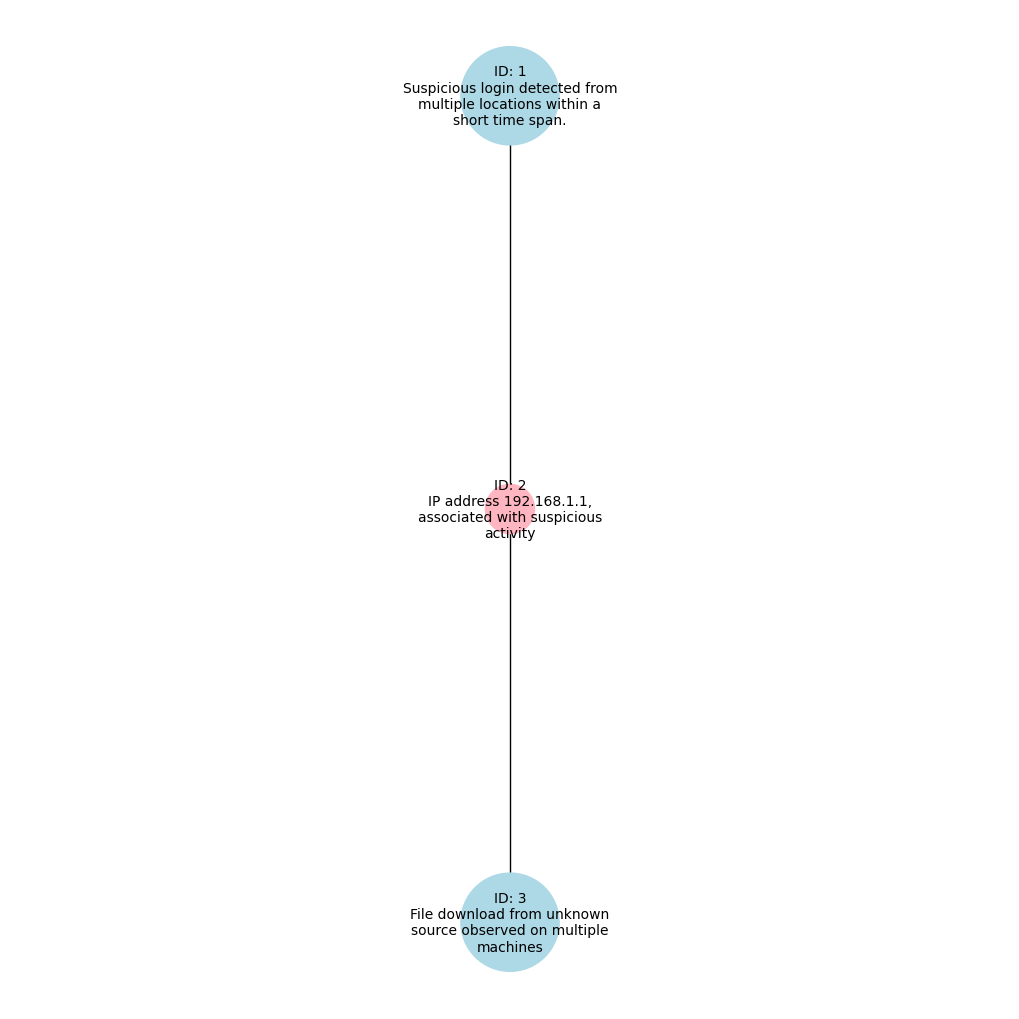

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

class SOCGraph:
    def __init__(self):
        self.G = nx.Graph()
        self.node_counter = 0
    
    def add_activity(self, description, from_ioc_id=None):
        # Create a new activity node with a unique ID
        self.node_counter += 1
        activity_id = self.node_counter
        self.G.add_node(activity_id, type='Activity', description=description)
        
        # If the activity is related to an existing IoC, add an edge between them
        if from_ioc_id is not None and self.G.has_node(from_ioc_id) and self.G.nodes[from_ioc_id]['type'] == 'IoC':
            self.G.add_edge(activity_id, from_ioc_id)
        
        return activity_id

    def delete_activity(self, activity_id):
        if self.G.has_node(activity_id) and self.G.nodes[activity_id]['type'] == 'Activity':
            self.G.remove_node(activity_id)
    
    def add_ioc(self, description, from_activity_id=None):
        # Create a new IoC node with a unique ID
        self.node_counter += 1
        ioc_id = self.node_counter
        self.G.add_node(ioc_id, type='IoC', description=description)
        
        # If the IoC is related to an existing activity, add an edge between them
        if from_activity_id is not None and self.G.has_node(from_activity_id) and self.G.nodes[from_activity_id]['type'] == 'Activity':
            self.G.add_edge(ioc_id, from_activity_id)
        
        return ioc_id
    
    def delete_ioc(self, ioc_id):
        if self.G.has_node(ioc_id) and self.G.nodes[ioc_id]['type'] == 'IoC':
            self.G.remove_node(ioc_id)

    def plot_custom_graph(self, root, figsize=(10, 10), base_node_size=5000, max_line_length=20):
        # Define node sizes and colors based on type
        node_sizes = []
        node_colors = []
        labels = {}

        for node, data in self.G.nodes(data=True):
            full_description = data['description']
            wrapped_description = "\n".join(textwrap.wrap(full_description, max_line_length))
            label = f"ID: {node}\n{wrapped_description}"
            labels[node] = label
            
            if data.get('type') == 'Activity':
                node_sizes.append(base_node_size)  # Size for type Activity
                node_colors.append('#ADD8E6')  # Light blue color for type Activity
            elif data.get('type') == 'IoC':
                node_sizes.append(base_node_size // 4)  # Smaller size for type IoC
                node_colors.append('#FFB6C1')  # Light pink color for type IoC

        # Define the custom tree layout
        pos = self.hierarchy_pos(root)
        
        # Set up the figure size
        plt.figure(figsize=figsize)
        
        # Draw the graph
        nx.draw(self.G, pos, with_labels=True, labels=labels, node_size=node_sizes, node_color=node_colors, font_size=10)

        # Show the plot
        plt.show()
    
    def hierarchy_pos(self, root):
        def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None):
            if pos is None:
                pos = {root: (xcenter, vert_loc)}
            else:
                pos[root] = (xcenter, vert_loc)
            neighbors = list(G.neighbors(root))
            if parent is not None:
                neighbors.remove(parent)  
            if len(neighbors) != 0:
                dx = width / len(neighbors) 
                nextx = xcenter - width / 2 - dx / 2
                for neighbor in neighbors:
                    nextx += dx
                    pos = _hierarchy_pos(G, neighbor, width=dx, vert_gap=vert_gap, 
                                         vert_loc=vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root)
            return pos
        
        return _hierarchy_pos(self.G, root)

# Example Usage
soc_graph = SOCGraph()
activity1 = soc_graph.add_activity("Suspicious login detected from multiple locations within a short time span.")
ioc1 = soc_graph.add_ioc("IP address 192.168.1.1, associated with suspicious activity", from_activity_id=activity1)
activity2 = soc_graph.add_activity("File download from unknown source observed on multiple machines", from_ioc_id=ioc1)

print("Graph Nodes:")
print(soc_graph.G.nodes(data=True))

print("\nGraph Edges:")
print(soc_graph.G.edges(data=True))

# Plotting the graph with a tree layout starting from activity1
soc_graph.plot_custom_graph(root=activity1, figsize=(10, 10), base_node_size=5000, max_line_length=30)


Graph Nodes:
[(1, {'type': 'Activity', 'description': 'A1: Suspicious email reading event through Graph API'}), (2, {'type': 'IoC', 'description': 'A1.IoC1: ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf'}), (3, {'type': 'Activity', 'description': 'A2: Check last authentication time of client app'}), (4, {'type': 'IoC', 'description': 'A2.IoC1: Service name: ReadEmailEWS using Graph API'}), (5, {'type': 'IoC', 'description': 'A2.IoC2: IP Address: 72.43.121.44'}), (6, {'type': 'Activity', 'description': 'A3: Credential added to client app ReadEmailEWS'}), (7, {'type': 'Activity', 'description': 'A4: Password spray attack from IP address 72.43.121.44'}), (8, {'type': 'Activity', 'description': 'A5: Client app used to enumerate users and applications with Graph API'})]

Graph Edges:
[(1, 2, {}), (2, 3, {}), (2, 8, {}), (3, 4, {}), (3, 5, {}), (4, 6, {}), (5, 7, {})]


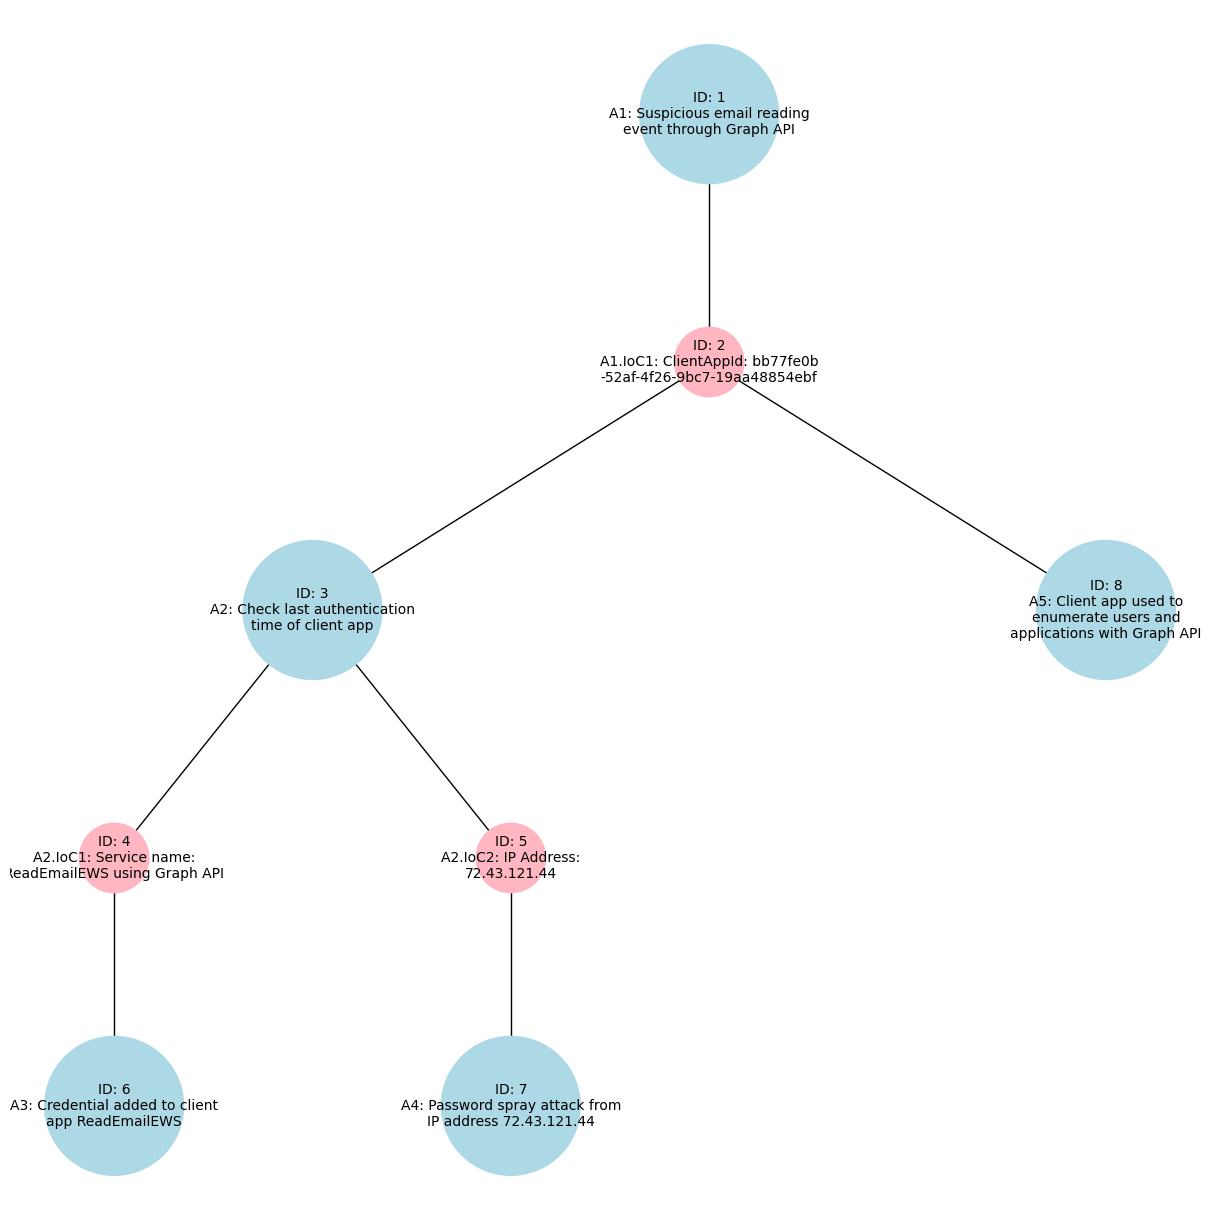

In [39]:
from soc_graph import SOCGraph

# Example Usage
soc_graph = SOCGraph()

# Adding activities and IoCs based on the report
# A1
activity1 = soc_graph.add_activity("A1: Suspicious email reading event through Graph API")
ioc1_a1 = soc_graph.add_ioc("A1.IoC1: ClientAppId: bb77fe0b-52af-4f26-9bc7-19aa48854ebf", from_activity_id=activity1)

# A2
activity2 = soc_graph.add_activity("A2: Check last authentication time of client app", from_ioc_id=ioc1_a1)
ioc1_a2 = soc_graph.add_ioc("A2.IoC1: Service name: ReadEmailEWS using Graph API", from_activity_id=activity2)
ioc2_a2 = soc_graph.add_ioc("A2.IoC2: IP Address: 72.43.121.44", from_activity_id=activity2)

# A3
activity3 = soc_graph.add_activity("A3: Credential added to client app ReadEmailEWS", from_ioc_id=ioc1_a2)

# A4
activity4 = soc_graph.add_activity("A4: Password spray attack from IP address 72.43.121.44", from_ioc_id=ioc2_a2)

# A5
activity5 = soc_graph.add_activity("A5: Client app used to enumerate users and applications with Graph API", from_ioc_id=ioc1_a1)

print("Graph Nodes:")
print(soc_graph.G.nodes(data=True))

print("\nGraph Edges:")
print(soc_graph.G.edges(data=True))

# Plotting the graph with a tree layout starting from activity1
soc_graph.plot_custom_graph(root=activity1, figsize=(12, 12), base_node_size=10000, max_line_length=30)
